[View in Colaboratory](https://colab.research.google.com/github/sonukick/backtests/blob/master/gap_research_metrics.ipynb)

### Back test results
### Strategy: Gap Strategy

Market: NSE-India

Data: Qunadl

Duration: 2012-01-01 to 2018-08-17

Segment: Stocks in NIFTY50 as of 2018-08-17

---



Rules:

1. If Gap Down more than 2% buy at opening 
2. If Gap up more than 2% short at opening
Returns: If gap is covered assumed day return = gap
If gap is not covered wait till EOD
**Prices are taken at Open/Close


---


* Maximum drawdown :            13.6%
* maximum intraday day loss:       9%
* maximum intraday profit :      19.8%


***Total returns                      :  591.21%**

CAGR: 47.20%


***Future developments:
extending to F&O stocks

changing the exit strategy: instead of holding till EOD, exiting at predetermined stoploss***





In [0]:
!pip install openpyxl
!pip install pydrive
!pip install quandl
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_list = drive.ListFile({'q': "'1P1c2VCcaHquJC0Fp5yfeiZjgqwNZlBEb' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))
data = drive.CreateFile({'id': '1cqSAgTq8Q7a-YLDoEwW312aAxZHY3MuG'})
data.GetContentFile('ind_nifty50list.csv')
api_key = 'rEwesR5TKDXzjNe-7kfj'
quandl.ApiConfig.api_key = api_key
#from google.colab import files
#uploaded = files.upload()
#symbols = pd.read_csv(io.StringIO(uploaded['ind_nifty50list.csv'].decode('utf-8')))

symbols = pd.read_csv('ind_nifty50list.csv')
symbols = symbols['Symbol']
symbols[0]
gaps_list = []
gaps_list.append(('Date','symbol','Open','prv_Close','Close','High','Low','Gap'))

for j in symbols:
  print(j)
  try:
    data = quandl.get('NSE/'+str(j), start_date='2012-01-1', end_date='2018-08-20')
  except:
    continue
  for i in range(len(data.Close)-1):
    if data.Open[i+1]<data.Close[i]*0.98:
      gaps_list.append((data.index[i+1],j,data.Open[i+1],data.Close[i],data.Close[i+1],data.High[i+1],data.Low[i+1],np.round((data.Open[i+1]/data.Close[i])-1,3)))
    if data.Open[i+1]>data.Close[i]*1.02:
      gaps_list.append((data.index[i+1],j,data.Open[i+1],data.Close[i],data.Close[i+1],data.High[i+1],data.Low[i+1],np.round((data.Open[i+1]/data.Close[i])-1,3)))



In [0]:
df = pd.DataFrame(gaps_list)

In [0]:
df.columns = df.iloc[0]
df =  df.iloc[1:]
covered_list = []
gap_left = 0
for i in range(1,len(df.Gap)+1):
  if df.Gap[i]<0:
    if df.High[i] >= df.prv_Close[i]:
          gap_left = 0
          covered_list.append(gap_left)
    else:
          gap_left = np.round(df.High[i]/df.prv_Close[i]-1,3)
          covered_list.append(gap_left)
   
  if df.Gap[i]>0:
    if df.Low[i] <= df.prv_Close[i]:
          gap_left = 0
          covered_list.append(gap_left)
    else:
          gap_left = np.round(df.Low[i]/df.prv_Close[i]-1,3)
          covered_list.append(gap_left)

In [0]:
return_list = []
return1 = 0
for i in range(1,len(df.Gap)+1):
  if df.Gap[i]<0:
    if df.High[i] >= df.prv_Close[i]:
          return1 = abs(df.Gap[i])
          return_list.append(return1)
    else:
          return1 = np.round(df.Close[i]/df.Open[i]-1,3)
          return_list.append(return1)
   
  if df.Gap[i]>0:
    if df.Low[i] <= df.prv_Close[i]:
          return1 = abs(df.Gap[i])
          return_list.append(return1)
    else:
          return1 = np.round(1-(df.Close[i]/df.Open[i]),3)
          return_list.append(return1)

In [0]:
df['gap_left'] = covered_list
df.Gap = df.Gap*100
df.gap_left = df.gap_left*100
df['percent_left'] = 100*df.gap_left/df.Gap
df['returns'] = return_list
df.returns = df.returns*100

In [0]:
frequency = pd.cut(df.percent_left,bins = range(-1,110,11))
sns.countplot(frequency)

#total gaps 
print(len(df))
#no of gaps with 100% covered
gap_stats = df.percent_left.value_counts()

In [0]:
#returns
dates = list(set(df.Date))

returns = 0
dates[1]
returns_data= []
daily_ret = 0
for i in dates:
  x = df[df.Date==i]
  
  daily_ret = np.round(np.average(x['returns']),2)
  returns_data.append((i,daily_ret))
returns_by_date = pd.DataFrame(returns_data)
returns_by_date.index = returns_by_date[0]
returns_by_date.drop(columns=0,inplace=True) 
returns_by_date['year'] = returns_by_date.index.year

In [0]:
cumulative = np.cumsum(returns_by_date[1])
cumulative = list(cumulative)

plt.title('Cumulative Returns')
plt.plot(cumulative)
plt.show()
xs = cumulative
i = np.argmax(np.maximum.accumulate(xs) - xs) # end of the period
j = np.argmax(xs[:i]) # start of period
print(cumulative[i],cumulative[j])
plt.plot(xs)
plt.plot([i, j], [xs[i], xs[j]], 'o', color='Red', markersize=5)


In [0]:
'''df.to_excel('gaps.xlsx')
from google.colab import files
files.download('gaps.xlsx')'''


In [0]:
'''returns_by_date.to_excel('returns_by_date.xlsx')
from google.colab import files
files.download('returns_by_date.xlsx')'''


/usr/local/lib/python3.6/dist-packages/pyfolio/tears.py:200: UserWarning: The latest version of pyfolio requires users to supply benchmark returns. Your current tearsheets will not include plots and analyses that require a benchmark. In the future, please pass benchmark_rets, or pass None to silence this warning.
  warnings.warn(BENCHMARK_RETS_WARNING)


Start date,2012-01-03
End date,2018-08-20
Total months,39
,Backtest
Annual return,541.7%
Cumulative returns,47936.5%
Annual volatility,41.5%
Sharpe ratio,4.70
Calmar ratio,24.89
Stability,0.85
Max drawdown,-21.8%


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,21.76,2017-05-10,2017-08-10,2018-02-06,195
1,20.94,2016-02-11,2016-05-31,2016-07-25,118
2,16.69,2015-09-23,2015-10-09,2015-12-18,63
3,14.81,2018-07-13,2018-07-30,NaT,NaN
4,14.76,2013-12-19,2014-02-24,2014-05-26,113


TypeError: ignored

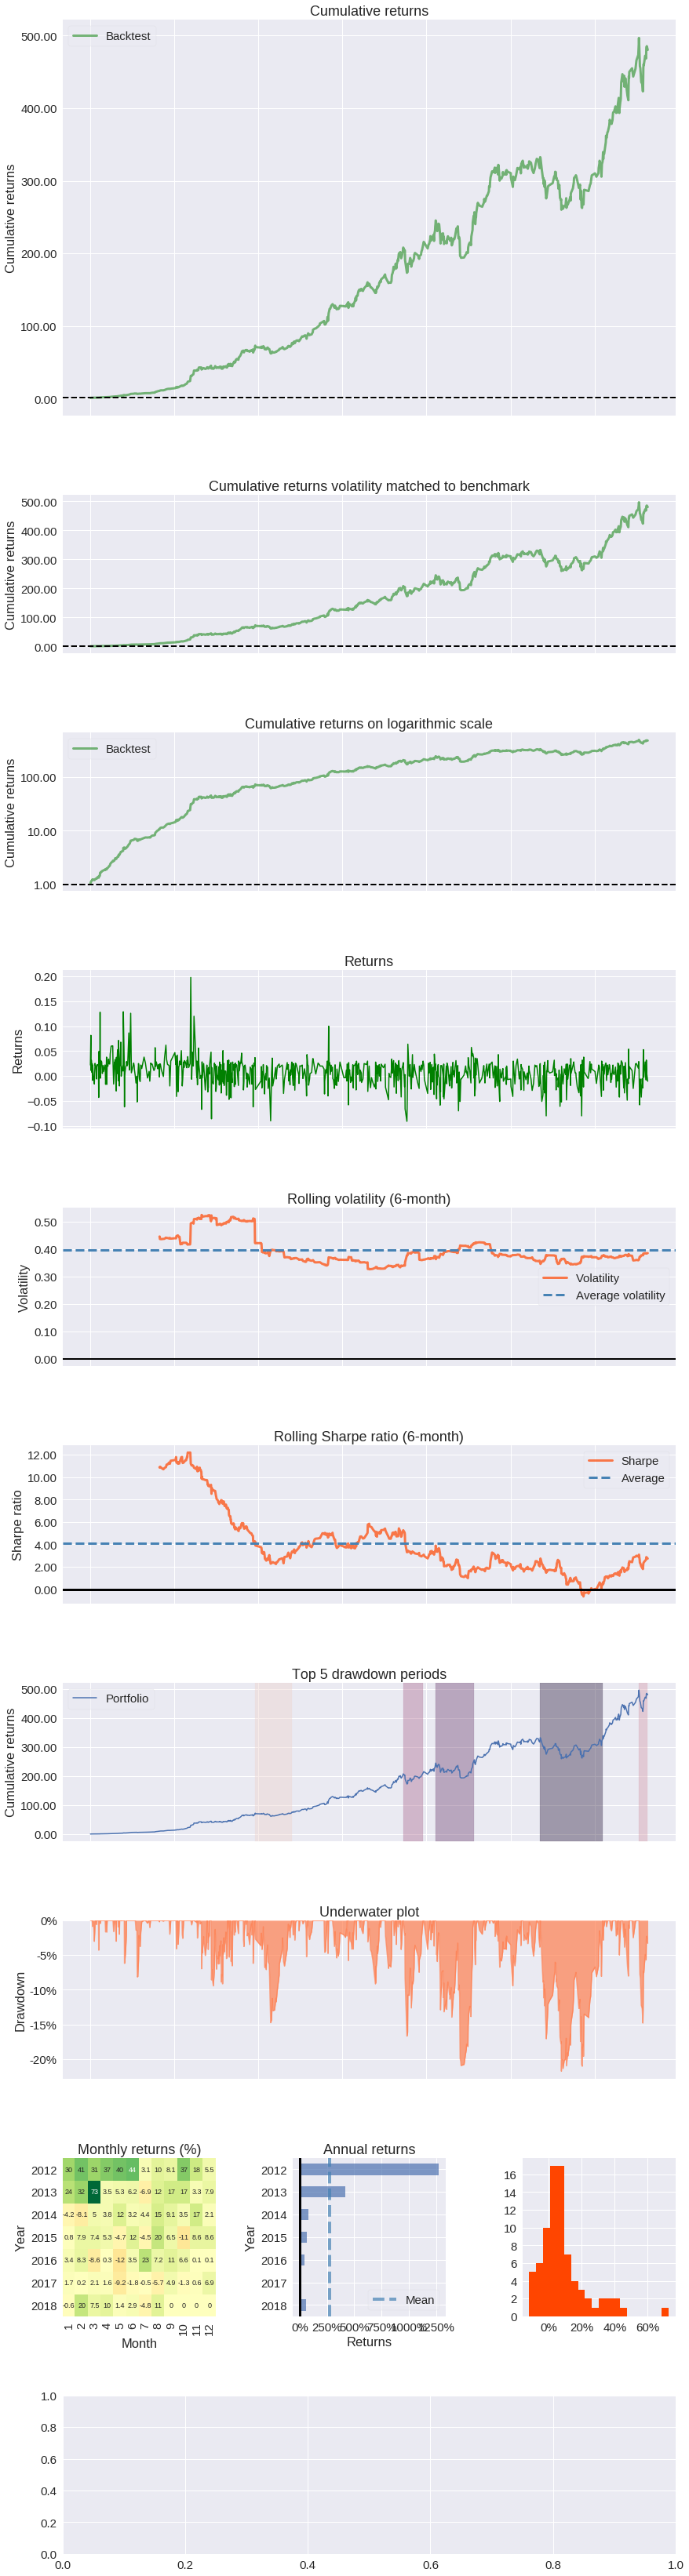

In [68]:
import pyfolio as pf

pf.create_full_tear_sheet(returns_by_date[1]/100)

In [67]:

returns_by_date[1] = 

0
2012-01-03     2.20
2012-01-05     8.17
2012-01-06     1.10
2012-01-07     3.20
2012-01-09     2.30
2012-01-10     0.70
2012-01-11     2.45
2012-01-12    -0.87
2012-01-13     2.10
2012-01-17    -0.80
2012-01-18    -0.65
2012-01-20    -1.60
2012-01-23     2.55
2012-01-24     2.20
2012-01-27     1.97
2012-01-30    -0.60
2012-01-31     2.10
2012-02-01     2.30
2012-02-03     2.10
2012-02-07     2.36
2012-02-08    -4.30
2012-02-09     4.93
2012-02-10     2.70
2012-02-13     1.10
2012-02-14    12.80
2012-02-15    -0.45
2012-02-16     0.30
2012-02-17     3.10
2012-02-21     2.85
2012-02-22     2.00
              ...  
2018-05-15     2.70
2018-05-23    -4.85
2018-05-24    -0.60
2018-05-28    -1.52
2018-05-29     5.40
2018-05-30     2.50
2018-05-31    -0.53
2018-06-01     1.90
2018-06-13     1.10
2018-06-18    -2.50
2018-06-28     2.45
2018-07-02     2.50
2018-07-10     1.60
2018-07-12     2.90
2018-07-13     2.00
2018-07-16    -5.80
2018-07-17    -2.13
2018-07-19    -0.60
2018-07-23    -4.2